In [1]:
import pandas as pd
import numpy as np
import re
import math
import json
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer

## Load datasets 

In [2]:
portfolio = pd.read_json('portfolio.json', lines=True)
profile = pd.read_json('profile.json', lines=True)
transcript = pd.read_json('transcript.json', lines=True)

print("The size of portfolio dataset is: ", portfolio.shape)
print("The size of profile dataset is: ", profile.shape)
print("The size of transcript dataset is: ", transcript.shape)
print()
display(portfolio.head(), profile.head(), transcript.head())

The size of portfolio dataset is:  (10, 6)
The size of profile dataset is:  (17000, 5)
The size of transcript dataset is:  (306534, 4)



,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## Data wrangling 

### clean the format 

**1) portfolio data: pivot channels**

In [3]:
# convert list object to strings
channels = portfolio.channels.apply(lambda x: ','.join(x))

# count unique channel frequency
count_vec = CountVectorizer()
channels = count_vec.fit_transform(channels)

# create channels vector
channels_vec = []
for channel, idx in count_vec.vocabulary_.items():
    channels_vec.append(channel)

# create dataframe
df_portfolio = pd.concat([portfolio.drop("channels", axis=1), 
                          pd.DataFrame(data=channels.todense(), columns=channels_vec)], axis=1)
df_portfolio.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [4]:
# create new column promotion_type by concatenating offer_type, reward, difficulty, and duration
df_portfolio["promotion_type"] = df_portfolio.offer_type.astype(str)+"_"+ \
                                df_portfolio.reward.astype(str)+"_"+ \
                                df_portfolio.difficulty.astype(str)+"_"+df_portfolio.duration.astype(str)

df_portfolio.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web,promotion_type
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,bogo_10_10_7
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_10_5
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,informational_0_0_4
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo_5_5_7
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,discount_5_20_10


**2) transcript data: clean the value**

In [5]:
# extract key and value from the dictionary
transcript = pd.read_json('transcript.json', lines=True)
transcript['value_type'] = transcript['value'].apply(lambda x: list(x.keys())[0])
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0])

# clean the value_type: change "offer_id" to "offer id"
transcript.value_type = transcript.value_type.apply(lambda x: re.sub(r"_", r" ", x))
transcript

,person,event,value,time,value_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer id
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer id
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0,offer id
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,offer id
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer id
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,1.59,714,amount
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,9.53,714,amount
306531,a00058cf10334a308c68e7631c529907,transaction,3.61,714,amount
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,3.53,714,amount


In [6]:
# separate offer_id and amount to two columns
transcript["offer_id"] = transcript[transcript.value_type=='offer id'].value
transcript["amount"] = transcript[transcript.value_type=='amount'].value
transcript.drop(["value", "value_type"], axis=1, inplace=True)
transcript

,person,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53


**3) profile data: clean the date format**

In [7]:
profile['member_year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
profile['member_month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
profile['became_member_on'] = profile.became_member_on.apply(lambda x: 
                                                             datetime.datetime.strptime(str(x), '%Y%m%d'))
profile.head()

,gender,age,id,became_member_on,income,member_year,member_month
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017,2
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018,7
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017,8


### merge dataframes 

In [8]:
transcript_profile = pd.merge(transcript, profile, how="left", 
                              left_on='person', right_on='id').drop("id", axis=1)

df_full = pd.merge(transcript_profile, df_portfolio, how="left", 
                   left_on = 'offer_id', right_on ='id').drop('id', axis=1)

df_full.amount = df_full.amount.astype(float)
print("The size of merged dataframe is: ", df_full.shape)
print()
print(df_full.info())
df_full.head()

The size of merged dataframe is:  (306534, 20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 20 columns):
person              306534 non-null object
event               306534 non-null object
time                306534 non-null int64
offer_id            167581 non-null object
amount              138953 non-null float64
gender              272762 non-null object
age                 306534 non-null int64
became_member_on    306534 non-null datetime64[ns]
income              272762 non-null float64
member_year         306534 non-null int64
member_month        306534 non-null int64
reward              167581 non-null float64
difficulty          167581 non-null float64
duration            167581 non-null float64
offer_type          167581 non-null object
email               167581 non-null float64
mobile              167581 non-null float64
social              167581 non-null float64
web                 167581 non-null float64
promotion_t

,person,event,time,offer_id,amount,gender,age,became_member_on,income,member_year,member_month,reward,difficulty,duration,offer_type,email,mobile,social,web,promotion_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,2017,5,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,bogo_5_5_7
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,None,118,2017-08-04,NaN,2017,8,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,discount_5_20_10
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,M,68,2018-04-26,70000.0,2018,4,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,discount_2_10_7
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,None,118,2017-09-25,NaN,2017,9,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,discount_2_10_10
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,None,118,2017-10-02,NaN,2017,10,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,bogo_10_10_5


### check missing values 

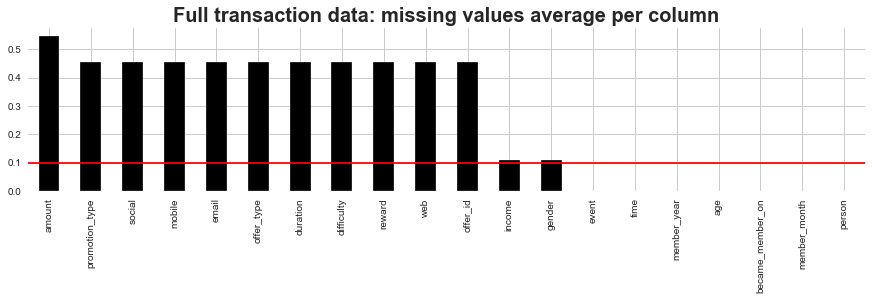

In [9]:
plt.style.use('seaborn')
sns.set_style('whitegrid')

plt.subplots(0,0,figsize=(15,3))

df_full.isnull().mean().sort_values(ascending=False).plot.bar(color='black')
plt.axhline(y=0.1, color='r', linestyle='-')
plt.title('Full transaction data: missing values average per column', fontsize=20, weight='bold' )
plt.show()

## Exploratory data analysis - visualization 

In [10]:
starbucks_palette = ["#00704A", "#eac784", "#362415", "#F0CDDB", "#E6A513", "#B15A11", 
                     "#f5ebda", "#79003C", "#F4AEB1", "#604c4c", ]

sns.set_style('white')
sns.set_palette(sns.color_palette(starbucks_palette))

#### profile analysis 

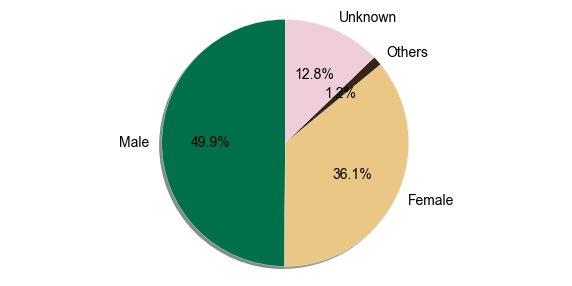

<Figure size 9600x6600 with 0 Axes>

In [11]:
profile["gender"] = profile["gender"].fillna('U')
labels = ['Male', 'Female', 'Others', 'Unknown']
sizes = [profile['gender'].value_counts()[0],
         profile['gender'].value_counts()[1],
         profile['gender'].value_counts()[3],
         profile['gender'].value_counts()[2]]

fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle = 90, shadow=True, 
        colors=starbucks_palette, textprops={'color':"black", 'fontsize': 14})
ax1.axis('equal')
plt.figure(dpi=1200)
plt.show()

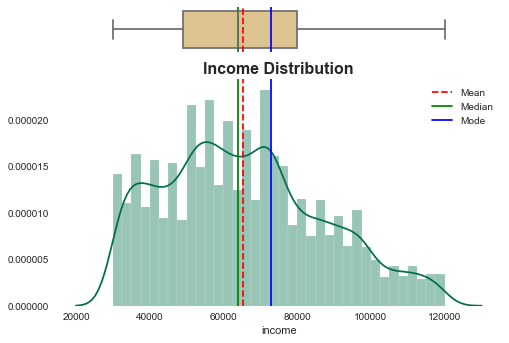

In [12]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
mean=profile.income.dropna().mean()
median=profile.income.dropna().median()
mode=profile.income.dropna().mode().to_numpy()[0]

sns.boxplot(profile.income.dropna(), color="#eac784", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.distplot(profile.income.dropna(), color='#00704A', ax=ax_hist)
ax_hist.axvline(mean, color='r', linestyle='--')
ax_hist.axvline(median, color='g', linestyle='-')
ax_hist.axvline(mode, color='b', linestyle='-')

plt.title('Income Distribution', weight='bold', fontsize=16)
plt.legend({'Mean':mean,'Median':median,'Mode':mode})

ax_box.set(xlabel='')
plt.show()

Text(133, 0.03, 'Abnormal age')

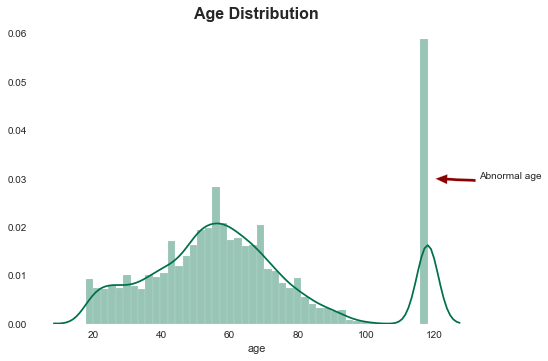

In [13]:
sns.distplot(profile.age.dropna(), color='#00704A')
plt.title('Age Distribution', weight='bold', fontsize=16)
plt.annotate('Abnormal age', xy=(120, 0.03), xytext=(133, 0.03),
             arrowprops=dict(facecolor='darkred', shrink=0.02, headwidth=10, width=3))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



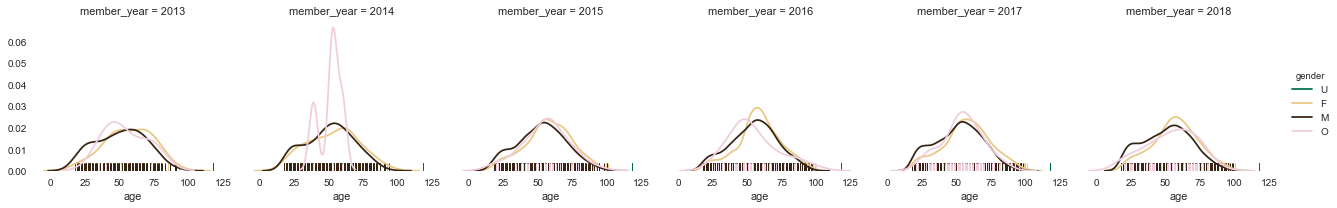

In [14]:
g = sns.FacetGrid(profile, col='member_year', hue="gender")
g = (g.map(sns.distplot, "age", hist=False, rug=True).add_legend())

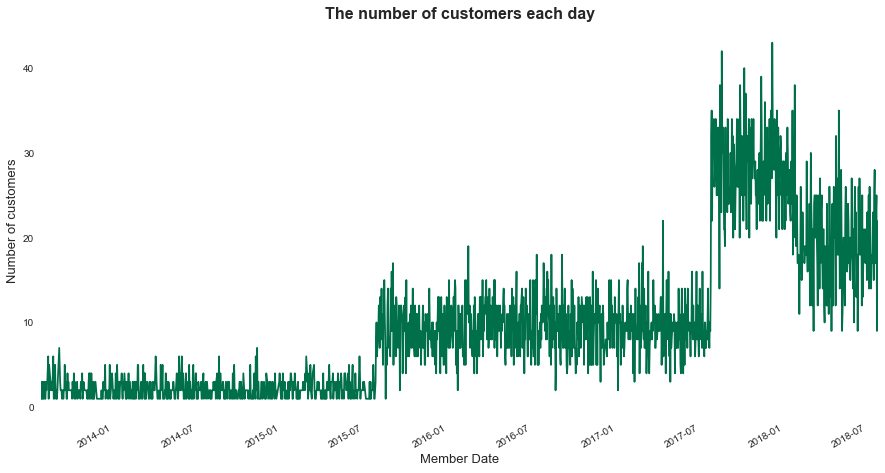

In [15]:
fig = plt.figure(figsize=(15,8))
profile.became_member_on.value_counts().plot(kind = 'line', color="#00704A")
plt.xlabel('Member Date', fontsize = 13)
plt.ylabel('Number of customers', fontsize = 13)
plt.title('The number of customers each day', weight='bold', fontsize=16);

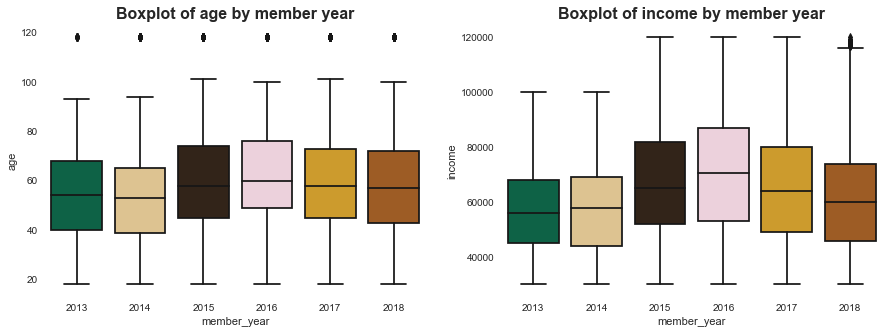

In [16]:
fig = plt.figure(figsize=(15,5))
ax0 = plt.subplot2grid((1,2),(0,0), rowspan=1, colspan=1)
sns.boxplot(x="member_year", y="age", data=profile)
plt.title('Boxplot of age by member year', weight='bold', fontsize=16)

ax1 = plt.subplot2grid((1,2),(0,1), rowspan=1, colspan=1)
sns.boxplot(x="member_year", y="income", data=profile)
plt.title('Boxplot of income by member year', weight='bold', fontsize=16)

plt.show()

#### portfolio analysis 

Text(0.5, 1.0, 'Countplot of duration')

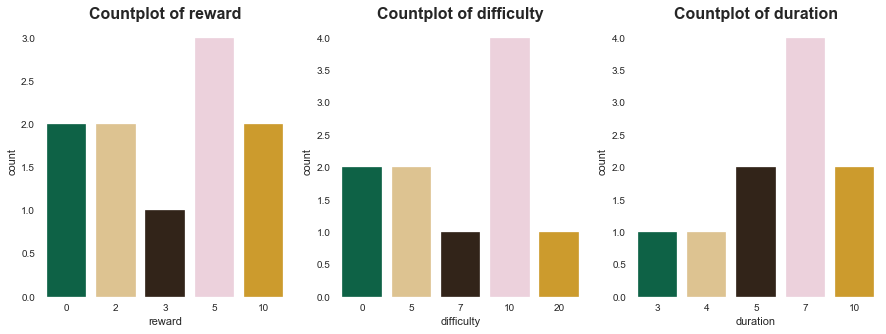

In [17]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,3),(0,0), rowspan=1, colspan=1)
sns.countplot(df_portfolio.reward, palette=starbucks_palette)
plt.title('Countplot of reward',weight='bold', fontsize=16)

ax2 = plt.subplot2grid((1,3),(0,1), rowspan=1, colspan=1)
sns.countplot(df_portfolio.difficulty, palette=starbucks_palette)
plt.title('Countplot of difficulty',weight='bold', fontsize=16)

ax3 = plt.subplot2grid((1,3),(0,2), rowspan=1, colspan=1)
sns.countplot(df_portfolio.duration, palette=starbucks_palette)
plt.title('Countplot of duration',weight='bold', fontsize=16)

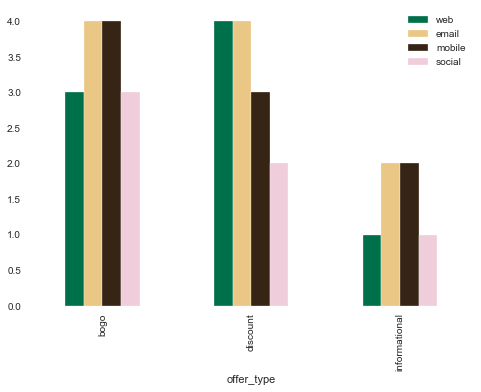

In [18]:
channels = ['web', 'email', 'mobile', 'social']
df_portfolio.groupby('offer_type')[channels].sum().plot(kind='bar', color=starbucks_palette)

#### joint dataframe analysis 

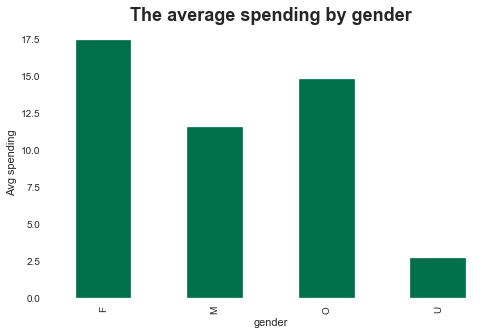

In [24]:
plt.figure(figsize=(8,5))
df_full["gender"] = df_full["gender"].fillna('U')
df_full.groupby('gender')['amount'].mean().plot(kind='bar')
plt.ylabel("Avg spending")
plt.title("The average spending by gender", weight="bold", fontsize=18);

Text(0.5, 1.05, 'Age, income and spending amount by gender')

<Figure size 1080x576 with 0 Axes>

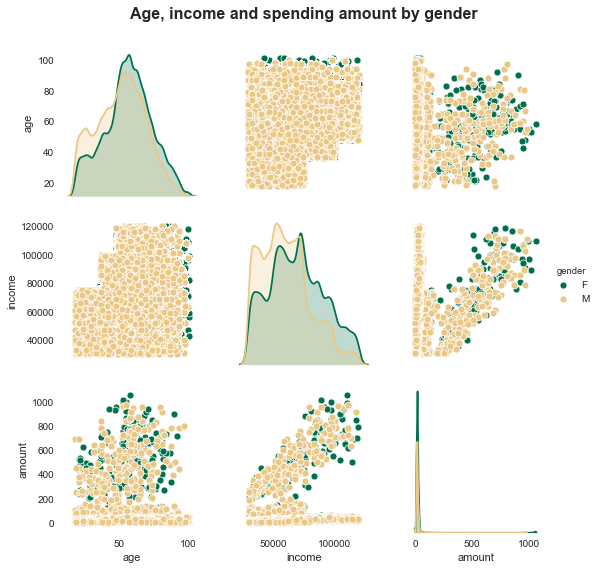

In [20]:
plt.figure(figsize=(15,8))
df = df_full[['gender', 'age', 'income', 'amount']].query('gender in ["F", "M"]')

g = sns.pairplot(df, hue='gender')
g.fig.suptitle("Age, income and spending amount by gender", y=1.05, weight='bold', fontsize=16)

*There are three ladder-like distribution between age and income: below age of 40, the income range tends to be [0,80000], age from 40 to 60, the income tends to be [80000, 100000], and age over 60, income tends to be [100000, 120000].*

Text(0.5, 1.0, 'Promotion Type by Event')

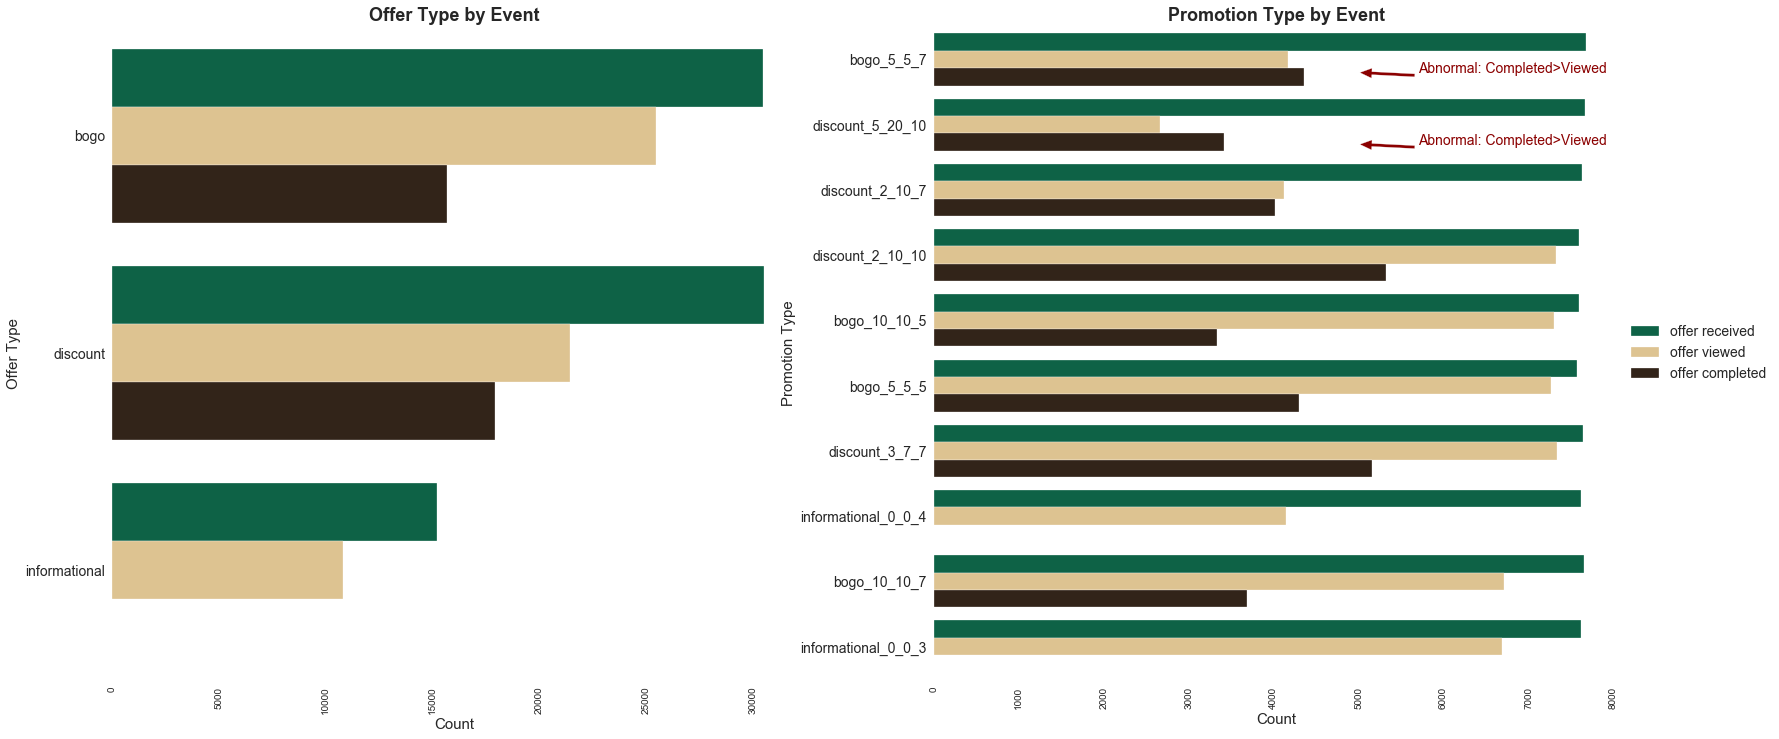

In [21]:
plt.figure(figsize=(27,12))

ax0 = plt.subplot2grid((1,2),(0,0), rowspan=1, colspan=1)
sns.countplot(y='offer_type', hue='event', data=df_full[df_full.event!='transaction'])
ax0.get_legend().remove()
plt.xticks(rotation=90)
plt.yticks(fontsize=14)
plt.xlabel("Count", fontsize=15)
plt.ylabel("Offer Type", fontsize=15)
plt.title("Offer Type by Event", weight='bold', fontsize=18)



ax1 = plt.subplot2grid((1,2),(0,1), rowspan=1, colspan=1)
sns.countplot(y='promotion_type', hue='event', data=df_full[df_full.event!='transaction'])

plt.annotate('Abnormal: Completed>Viewed', xy=(5000, 0.2), xytext=(5700, 0.2), fontsize=14, color="darkred",
             arrowprops=dict(facecolor='darkred', shrink=0.02, headwidth=10, width=3))

plt.annotate('Abnormal: Completed>Viewed', xy=(5000, 1.3), xytext=(5700, 1.3), fontsize=14, color="darkred",
             arrowprops=dict(facecolor='darkred', shrink=0.02, headwidth=10, width=3))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xticks(rotation=90)
plt.yticks(fontsize=14)
plt.xlabel("Count", fontsize=15)
plt.ylabel("Promotion Type", fontsize=15)
plt.title("Promotion Type by Event", weight='bold', fontsize=18)

Text(0.5, 1.0, 'Avg spendings by Month and Year')

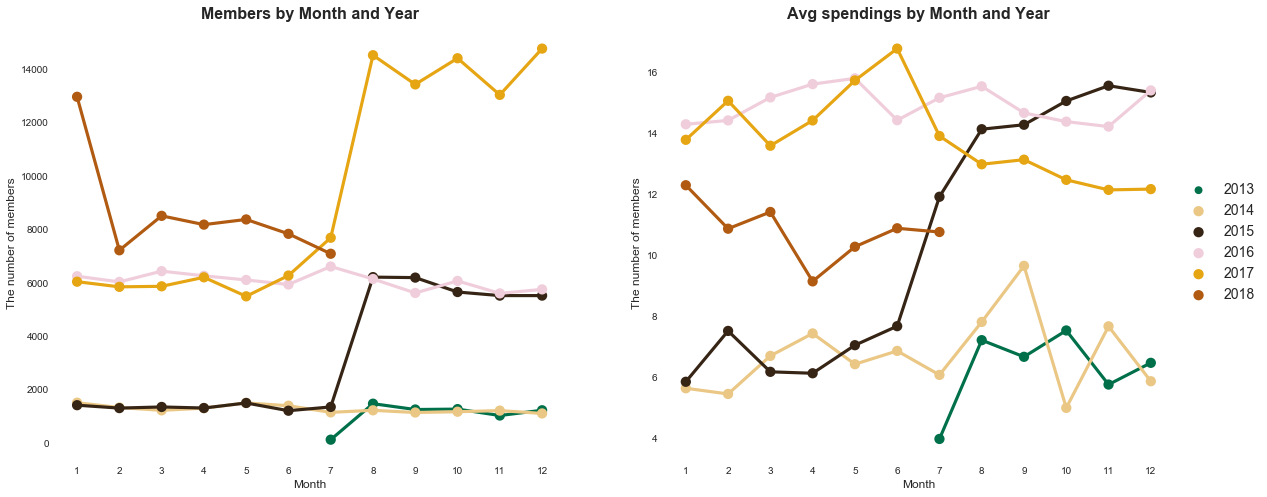

In [25]:
members = df_full.groupby(['member_year','member_month'], 
                          as_index=False).agg({'person':'count', 'amount':'mean'})

plt.figure(figsize=(20,8))
ax0 = plt.subplot2grid((1,2),(0,0), rowspan=1, colspan=1)
sns.pointplot(x="member_month", y="person", hue="member_year", data = members, palette=starbucks_palette)
ax0.get_legend().remove()
plt.ylabel('The number of members', fontsize = 12)
plt.xlabel('Month', fontsize = 12)
plt.title('Members by Month and Year', weight="bold", fontsize=16)

ax1 = plt.subplot2grid((1,2),(0,1), rowspan=1, colspan=1)
sns.pointplot(x="member_month", y="amount", hue="member_year", data = members, palette=starbucks_palette)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.ylabel('The number of members', fontsize = 12)
plt.xlabel('Month', fontsize = 12)
plt.title('Avg spendings by Month and Year', weight="bold", fontsize=16)

## Feature engineering 

#### age outliers 

In [15]:
len(profile[profile.age>100])/len(profile)

0.12823529411764706

In [ ]:
df_full_normalage = df_full[df_full.age<100]
len(df_full_normalage)

#### offer completed without viewing 

####  

## Clustering algorithm